### Weather forecasting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load the data

In [2]:
csv_path = "/Users/airwoot/Documents/Anuj/Warehouse/jena_climate/jena_climate_2009_2016.csv"

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(csv_path)
col_names = list(df)

In [5]:
print(len(df))
print(list(df))
print(df.head())

420551
['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26   

### Plot some basic values

In [6]:
from matplotlib import pyplot as plt

In [7]:
#df['T (degC)'].tolist()

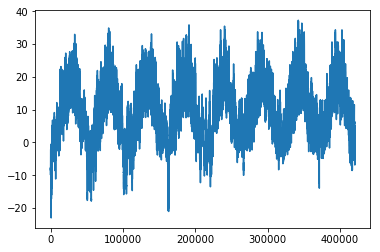

In [8]:
plt.plot(df['T (degC)'].tolist())

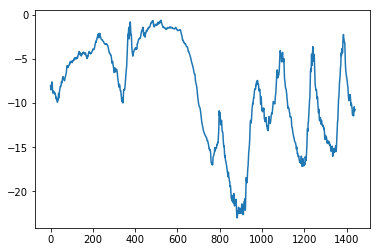

In [9]:
plt.plot(df['T (degC)'].tolist()[:1440])

In [ ]:
df['p (mbar)'].plot(kind='bar')
plt.show()

AttributeError: Unknown property kind

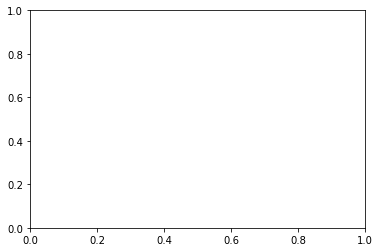

In [11]:
# plt.plot(df['p (mbar)'].tolist(), kind='bar')

### Normalize data

In [14]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pandas.DataFrame(x_scaled)

ValueError: invalid literal for float(): 01.01.2017 00:00:00

In [ ]:
df['p (mbar)'].plot(kind='bar')
plt.show()

In [ ]:
###

In [15]:


f = open(csv_path)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [16]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [17]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [18]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [20]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['acc'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 40s 80ms/step - loss: 0.3825 - acc: 0.0000e+00 - val_loss: 0.3528 - val_acc: 0.0000e+00
Epoch 2/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2566 - acc: 0.0000e+00 - val_loss: 0.3312 - val_acc: 0.0000e+00
Epoch 3/20
500/500 [==============================] - 42s 85ms/step - loss: 0.2216 - acc: 0.0000e+00 - val_loss: 0.3372 - val_acc: 0.0000e+00
Epoch 4/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2056 - acc: 0.0000e+00 - val_loss: 0.3346 - val_acc: 0.0000e+00
Epoch 5/20
500/500 [==============================] - 47s 94ms/step - loss: 0.1932 - acc: 0.0000e+00 - val_loss: 0.3573 - val_acc: 0.0000e+00
Epoch 6/20
500/500 [==============================] - 45s 90ms/step - loss: 0.1845 - acc: 0.0000e+00 - val_loss: 0.3457 - val_acc: 0.0000e+00
Epoch 7/20
500/500 [==============================] - 41s 83ms/step - loss: 0.1769 - acc: 0.0000e+00 - val_loss: 0.3354 - val_acc: 0.0000e+00
Epoch

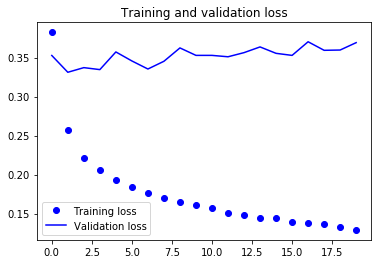

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()